In [ ]:
# Run this if your data is in Google Drive. If your files are already in /content/DEEPVISION, skip.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive


/content/drive/MyDrive


In [ ]:
!ls -lh

total 3.2G
drwx------ 2 root root 4.0K Nov 28 07:25 'Colab Notebooks'
-rw------- 1 root root 3.2G Nov 28 07:09  DEEPVISION.zip


In [ ]:
!unzip -q DEEPVISION.zip -d /content

In [ ]:
!ls /content

DEEPVISION  drive  sample_data


In [ ]:
!find /content/DEEPVISION -type f -iname "*.jpg" | wc -l
!find /content/DEEPVISION -type f -iname "*.npy" | wc -l

1201
332


In [ ]:
!find /content/DEEPVISION -type d -maxdepth 5 | sort

find: warning: you have specified the global option -maxdepth after the argument -type, but global options are not positional, i.e., -maxdepth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.
/content/DEEPVISION
/content/DEEPVISION/DATA
/content/DEEPVISION/DATA/processed
/content/DEEPVISION/DATA/processed/part_A
/content/DEEPVISION/DATA/processed/part_A/density
/content/DEEPVISION/DATA/ShanghaiTech
/content/DEEPVISION/DATA/ShanghaiTech/part_A
/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data
/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/ground-truth
/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/images
/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data
/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/ground-truth
/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images
/content/DEEPVISION/DATA/ShanghaiTech/part_B
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data
/co

In [ ]:
!echo "---- IMAGES ----"
!find /content/DEEPVISION -type f -iname "*.jpg" | head -20

!echo "---- NPY ----"
!find /content/DEEPVISION -type f -iname "*.npy" | head -20

---- IMAGES ----
/content/DEEPVISION/venv/Lib/site-packages/matplotlib/mpl-data/sample_data/grace_hopper.jpg
/content/DEEPVISION/venv/Lib/site-packages/sklearn/datasets/images/china.jpg
/content/DEEPVISION/venv/Lib/site-packages/sklearn/datasets/images/flower.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_2.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_207.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_17.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_93.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_41.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_114.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_267.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_32.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_199.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_264.jpg
/c

In [ ]:
# Paths for your dataset
IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

# Check both exist and count files
import os

print("Images folder exists:", os.path.exists(IMG_DIR))
print("Density folder exists:", os.path.exists(DEN_DIR))

print("Images count:", len([f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]))
print("Density maps count:", len([f for f in os.listdir(DEN_DIR) if f.endswith(".npy")]))

Images folder exists: True
Density folder exists: True
Images count: 300
Density maps count: 300


In [ ]:
!find /content/DEEPVISION -type d -iname "*density*"

/content/DEEPVISION/DATA/processed/part_A/density


In [ ]:
!pip install torch torchvision opencv-python

In [ ]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir = img_dir
        self.den_dir = den_dir

        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.dens   = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])

        assert len(self.images) == len(self.dens), "Image–Density count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        den_path = os.path.join(self.den_dir, self.dens[idx])

        # Load image → 512x512
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)

        # Load density → MUST BE 32x32
        den = np.load(den_path).astype(np.float32)
        den = cv2.resize(den, (32, 32))
        den = torch.tensor(den).unsqueeze(0)

        return img, den

In [ ]:
from torch.utils.data import DataLoader

ds = CrowdDataset(IMG_DIR, DEN_DIR)
train_loader = DataLoader(ds, batch_size=2, shuffle=True)

print("Total training samples:", len(ds))

Total training samples: 300


In [ ]:
import torch.nn as nn
from torchvision.models import vgg16

class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.features = nn.Sequential(*list(vgg.features.children())[:30])

        self.regressor = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0

    for imgs, dens in train_loader:
        imgs = imgs.to(device)
        dens = dens.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch}/{EPOCHS}  Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "model_epoch_50.pth")
print("Saved model_epoch_50.pth")

Epoch 1/50  Loss: 0.0168
Epoch 2/50  Loss: 0.0028
Epoch 3/50  Loss: 0.0019
Epoch 4/50  Loss: 0.0017
Epoch 5/50  Loss: 0.0015
Epoch 6/50  Loss: 0.0014
Epoch 7/50  Loss: 0.0013
Epoch 8/50  Loss: 0.0012
Epoch 9/50  Loss: 0.0012
Epoch 10/50  Loss: 0.0011
Epoch 11/50  Loss: 0.0011
Epoch 12/50  Loss: 0.0011
Epoch 13/50  Loss: 0.0010
Epoch 14/50  Loss: 0.0010
Epoch 15/50  Loss: 0.0010
Epoch 16/50  Loss: 0.0010
Epoch 17/50  Loss: 0.0010
Epoch 18/50  Loss: 0.0009
Epoch 19/50  Loss: 0.0009
Epoch 20/50  Loss: 0.0009
Epoch 21/50  Loss: 0.0009
Epoch 22/50  Loss: 0.0009
Epoch 23/50  Loss: 0.0009
Epoch 24/50  Loss: 0.0009
Epoch 25/50  Loss: 0.0009
Epoch 26/50  Loss: 0.0009
Epoch 27/50  Loss: 0.0008
Epoch 28/50  Loss: 0.0008
Epoch 29/50  Loss: 0.0009
Epoch 30/50  Loss: 0.0008
Epoch 31/50  Loss: 0.0008
Epoch 32/50  Loss: 0.0008
Epoch 33/50  Loss: 0.0008
Epoch 34/50  Loss: 0.0008
Epoch 35/50  Loss: 0.0008
Epoch 36/50  Loss: 0.0008
Epoch 37/50  Loss: 0.0008
Epoch 38/50  Loss: 0.0008
Epoch 39/50  Loss: 0.

In [ ]:
# confirm dataset & any checkpoint
import os
IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"
print("Images exist:", os.path.exists(IMG_DIR), "count:", len(os.listdir(IMG_DIR)) if os.path.exists(IMG_DIR) else 0)
print("Density exist:", os.path.exists(DEN_DIR), "count:", len(os.listdir(DEN_DIR)) if os.path.exists(DEN_DIR) else 0)
print("Any checkpoint files here?")
for f in os.listdir("/content"):
    if "model_epoch" in f or f.endswith(".pth"):
        print(" -", f)
# also check drive output if you saved there:
DR = "/content/drive/MyDrive"
if os.path.exists(DR):
    for f in os.listdir(DR):
        if f.endswith(".pth") or "model_epoch" in f:
            print("Drive:",f)

Images exist: True count: 300
Density exist: True count: 300
Any checkpoint files here?
Drive: model_epoch_50.pth


In [ ]:
# ---------- TRAIN FROM SCRATCH FOR 100 EPOCHS ----------
import os, cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
from tqdm import tqdm

IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir, self.den_dir = img_dir, den_dir
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.dens   = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])
        self.pairs = [(os.path.join(img_dir, os.path.splitext(f)[0]+'.jpg'),
                       os.path.join(den_dir, os.path.splitext(f)[0]+'.npy'))
                      for f in self.images if os.path.splitext(f)[0]+'.npy' in self.dens]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512)).astype('float32')/255.0
        img = torch.from_numpy(img).permute(2,0,1)
        den = np.load(denp).astype('float32')
        den = cv2.resize(den, (32,32))
        den = torch.from_numpy(den).unsqueeze(0)
        return img, den

ds = CrowdDataset(IMG_DIR, DEN_DIR)
loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)

# simple CSRNet-like model
class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512,256,3,padding=1), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,1,1)
        )
    def forward(self,x):
        x = self.backbone(x)
        x = self.regressor(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    model.train()
    total=0.0
    for imgs, dens in loader:
        imgs = imgs.to(device); dens = dens.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        if preds.shape[-2:] != dens.shape[-2:]:
            dens = torch.nn.functional.interpolate(dens, size=preds.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch}/{EPOCHS}  AvgLoss:{total/len(loader):.6f}")
    if epoch%10==0 or epoch==EPOCHS:
        torch.save(model.state_dict(), f"/content/model_epoch_{epoch}.pth")
        print("Saved checkpoint:", f"/content/model_epoch_{epoch}.pth")

# final save (redundant)
torch.save(model.state_dict(), "/content/model_epoch_100.pth")
print("Final model saved: /content/model_epoch_100.pth")

Epoch 1/100  AvgLoss:0.000505
Epoch 2/100  AvgLoss:0.000048
Epoch 3/100  AvgLoss:0.000020
Epoch 4/100  AvgLoss:0.000013
Epoch 5/100  AvgLoss:0.000009
Epoch 6/100  AvgLoss:0.000008
Epoch 7/100  AvgLoss:0.000007
Epoch 8/100  AvgLoss:0.000007
Epoch 9/100  AvgLoss:0.000006
Epoch 10/100  AvgLoss:0.000005
Saved checkpoint: /content/model_epoch_10.pth
Epoch 11/100  AvgLoss:0.000005
Epoch 12/100  AvgLoss:0.000005
Epoch 13/100  AvgLoss:0.000005
Epoch 14/100  AvgLoss:0.000005
Epoch 15/100  AvgLoss:0.000005
Epoch 16/100  AvgLoss:0.000004
Epoch 17/100  AvgLoss:0.000004
Epoch 18/100  AvgLoss:0.000004
Epoch 19/100  AvgLoss:0.000004
Epoch 20/100  AvgLoss:0.000004
Saved checkpoint: /content/model_epoch_20.pth
Epoch 21/100  AvgLoss:0.000004
Epoch 22/100  AvgLoss:0.000004
Epoch 23/100  AvgLoss:0.000004
Epoch 24/100  AvgLoss:0.000004
Epoch 25/100  AvgLoss:0.000004
Epoch 26/100  AvgLoss:0.000004
Epoch 27/100  AvgLoss:0.000004
Epoch 28/100  AvgLoss:0.000004
Epoch 29/100  AvgLoss:0.000004
Epoch 30/100  AvgL

In [ ]:
import torch
print("cuda:", torch.cuda.is_available())

cuda: True


In [ ]:
print("Dataset size:", len(ds))
for imgs, dens in train_loader:
    print("One batch OK:", imgs.shape, dens.shape)
    break

Dataset size: 300
One batch OK: torch.Size([2, 3, 512, 512]) torch.Size([2, 1, 32, 32])


In [ ]:
test = model(torch.randn(1,3,512,512).to(device))
print("Model output shape:", test.shape)

Model output shape: torch.Size([1, 1, 64, 64])


In [ ]:
import numpy as np

import os

a = np.load(os.path.join(DEN_DIR, os.listdir(DEN_DIR)[0]))
print(a.shape)

(405, 540)


In [ ]:
# ---------- TRAIN FROM SCRATCH FOR 150 EPOCHS ----------
import os, cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
from tqdm import tqdm

IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir, self.den_dir = img_dir, den_dir
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.dens   = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])
        self.pairs = [(os.path.join(img_dir, os.path.splitext(f)[0]+'.jpg'),
                       os.path.join(den_dir, os.path.splitext(f)[0]+'.npy'))
                      for f in self.images if os.path.splitext(f)[0]+'.npy' in self.dens]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512)).astype('float32')/255.0
        img = torch.from_numpy(img).permute(2,0,1)
        den = np.load(denp).astype('float32')
        den = cv2.resize(den, (32,32))
        den = torch.from_numpy(den).unsqueeze(0)
        return img, den

ds = CrowdDataset(IMG_DIR, DEN_DIR)
loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)

# simple CSRNet-like model
class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512,256,3,padding=1), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,1,1)
        )
    def forward(self,x):
        x = self.backbone(x)
        x = self.regressor(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 150
for epoch in range(1, EPOCHS+1):
    model.train()
    total=0.0
    for imgs, dens in loader:
        imgs = imgs.to(device); dens = dens.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        if preds.shape[-2:] != dens.shape[-2:]:
            dens = torch.nn.functional.interpolate(dens, size=preds.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch}/{EPOCHS}  AvgLoss:{total/len(loader):.6f}")
    if epoch%10==0 or epoch==EPOCHS:
        torch.save(model.state_dict(), f"/content/model_epoch_{epoch}.pth")
        print("Saved checkpoint:", f"/content/model_epoch_{epoch}.pth")

# final save (redundant)
torch.save(model.state_dict(), "/content/model_epoch_150.pth")
print("Final model saved: /content/model_epoch_150.pth")

Epoch 1/150  AvgLoss:0.000355
Epoch 2/150  AvgLoss:0.000027
Epoch 3/150  AvgLoss:0.000014
Epoch 4/150  AvgLoss:0.000010
Epoch 5/150  AvgLoss:0.000008
Epoch 6/150  AvgLoss:0.000007
Epoch 7/150  AvgLoss:0.000006
Epoch 8/150  AvgLoss:0.000006
Epoch 9/150  AvgLoss:0.000005
Epoch 10/150  AvgLoss:0.000005
Saved checkpoint: /content/model_epoch_10.pth
Epoch 11/150  AvgLoss:0.000005
Epoch 12/150  AvgLoss:0.000005
Epoch 13/150  AvgLoss:0.000005
Epoch 14/150  AvgLoss:0.000004
Epoch 15/150  AvgLoss:0.000004
Epoch 16/150  AvgLoss:0.000004
Epoch 17/150  AvgLoss:0.000004
Epoch 18/150  AvgLoss:0.000004
Epoch 19/150  AvgLoss:0.000004
Epoch 20/150  AvgLoss:0.000004
Saved checkpoint: /content/model_epoch_20.pth
Epoch 21/150  AvgLoss:0.000004
Epoch 22/150  AvgLoss:0.000004
Epoch 23/150  AvgLoss:0.000004
Epoch 24/150  AvgLoss:0.000004
Epoch 25/150  AvgLoss:0.000004
Epoch 26/150  AvgLoss:0.000004
Epoch 27/150  AvgLoss:0.000003
Epoch 28/150  AvgLoss:0.000003
Epoch 29/150  AvgLoss:0.000004
Epoch 30/150  AvgL

In [ ]:
# 1. list checkpoints
!ls -lh /content/model_epoch_*.pth

# 2. quick forward pass (sanity)
import torch, numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "/content/model_epoch_150.pth"
model = CrowdCounter().to(device)          # use your CrowdCounter class from notebook
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# take one batch from loader
imgs, dens = next(iter(loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)
print("imgs", imgs.shape, "preds", preds.shape, "gt", dens.shape)

-rw-r--r-- 1 root root 35M Nov 28 10:20 /content/model_epoch_100.pth
-rw-r--r-- 1 root root 35M Nov 28 09:40 /content/model_epoch_10.pth
-rw-r--r-- 1 root root 35M Nov 28 10:25 /content/model_epoch_110.pth
-rw-r--r-- 1 root root 35M Nov 28 10:29 /content/model_epoch_120.pth
-rw-r--r-- 1 root root 35M Nov 28 10:34 /content/model_epoch_130.pth
-rw-r--r-- 1 root root 35M Nov 28 10:38 /content/model_epoch_140.pth
-rw-r--r-- 1 root root 35M Nov 28 10:43 /content/model_epoch_150.pth
-rw-r--r-- 1 root root 35M Nov 28 09:44 /content/model_epoch_20.pth
-rw-r--r-- 1 root root 35M Nov 28 09:49 /content/model_epoch_30.pth
-rw-r--r-- 1 root root 35M Nov 28 09:53 /content/model_epoch_40.pth
-rw-r--r-- 1 root root 35M Nov 28 09:58 /content/model_epoch_50.pth
-rw-r--r-- 1 root root 35M Nov 28 10:02 /content/model_epoch_60.pth
-rw-r--r-- 1 root root 35M Nov 28 10:07 /content/model_epoch_70.pth
-rw-r--r-- 1 root root 35M Nov 28 10:11 /content/model_epoch_80.pth
-rw-r--r-- 1 root root 35M Nov 28 10:16 /c

In [ ]:
# ====== TEST DATASET ======

TEST_IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/images"
TEST_DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

test_ds = CrowdDataset(TEST_IMG_DIR, TEST_DEN_DIR)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Test samples:", len(test_ds))

Test samples: 182


In [ ]:
mae, rmse = evaluate_mae_rmse(model, test_loader, device=device)
print("MAE:", mae, "RMSE:", rmse)

MAE: 4.146615 RMSE: 6.191793782232998


In [ ]:
import torch
import math

def evaluate_mae_rmse(model, data_loader, device="cpu"):
    model.eval()
    mae_sum = 0.0
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for imgs, dens in data_loader:
            imgs = imgs.to(device)
            dens = dens.to(device)
            if dens.dim()==3: dens = dens.unsqueeze(1)
            preds = model(imgs)
            # resize gt -> pred size if needed
            if preds.shape[2:] != dens.shape[2:]:
                dens_res = torch.nn.functional.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)
            else:
                dens_res = dens
            # sum over spatial dims
            pred_counts = preds.sum(dim=(1,2,3)).cpu().numpy()
            gt_counts   = dens_res.sum(dim=(1,2,3)).cpu().numpy()
            mae_sum += (abs(pred_counts - gt_counts)).sum()
            mse_sum += ((pred_counts - gt_counts)**2).sum()
            n += imgs.size(0)
    mae = mae_sum / n
    rmse = math.sqrt(mse_sum / n)
    return mae, rmse

# use your saved model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
model.load_state_dict(torch.load("/content/model_epoch_150.pth", map_location=device))

# create test_loader – replace with your actual test DataLoader creation:
# test_ds = CrowdDataset(TEST_IMG_DIR, TEST_DEN_DIR)
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
mae, rmse = evaluate_mae_rmse(model, test_loader, device=device)
print("MAE:", mae, "RMSE:", rmse)

MAE: 4.146615 RMSE: 6.191793782232998


In [ ]:
import cv2, os, numpy as np

def downsample_preserve_sum(den, new_shape):
    # den: numpy array HxW
    # new_shape: (h_out, w_out)
    h, w = den.shape
    h2, w2 = new_shape
    # use cv2.INTER_AREA (gives averaged values), then multiply by factor to preserve sum
    den_small = cv2.resize(den, (w2, h2), interpolation=cv2.INTER_AREA)
    scale = (h*w) / (h2*w2)
    den_small_sum_preserved = den_small * scale
    return den_small_sum_preserved

# Example: iterate over your density folder and save new files
den_dir = "/content/DEEPVISION/DATA/processed/part_A/density"
out_dir = "/content/DEEPVISION/DATA/processed/part_A/density_down32"  # e.g.
os.makedirs(out_dir, exist_ok=True)
for f in os.listdir(den_dir):
    if not f.endswith(".npy"): continue
    den = np.load(os.path.join(den_dir, f))
    den_small = downsample_preserve_sum(den, (32,32))   # change to target
    np.save(os.path.join(out_dir, f), den_small)



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrowdCounter(nn.Module):
    def __init__(self):
        super(CrowdCounter, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)      # 512 → 256
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)      # 256 → 128
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)      # 128 → 64
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)      # 64 → 32
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )
        self.output_layer = nn.Conv2d(256, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.output_layer(x)
        return x

In [9]:
import os, cv2, numpy as np, torch
from torch.utils.data import Dataset

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir = img_dir
        self.den_dir = den_dir

        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.dens   = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])

        assert len(self.images) == len(self.dens), f"Count mismatch: {len(self.images)} images vs {len(self.dens)} maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        den_path = os.path.join(self.den_dir, self.dens[idx])

        # image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512)).astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2,0,1)

        # density map
        den = np.load(den_path).astype(np.float32)
        den = cv2.resize(den, (32, 32))
        den = torch.tensor(den).unsqueeze(0)

        return img, den

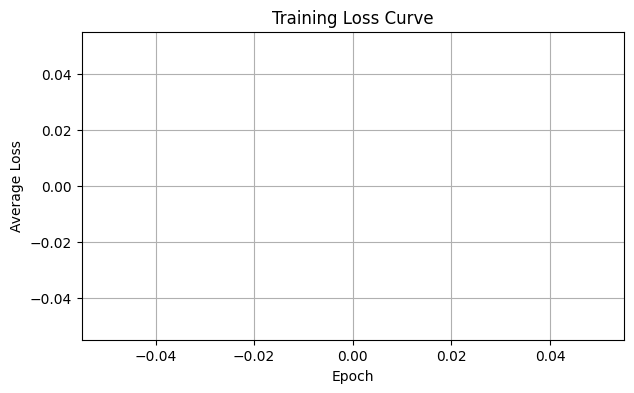

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

GENERAL TESTING (MAE + RMSE)
 **Define Testing Dataset**

In [ ]:
import os, cv2, torch, numpy as np
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

class TestDataset(Dataset):
    def __init__(self, img_dir, mat_dir):
        self.img_dir = img_dir
        self.mat_dir = mat_dir
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        # ---- Load Image ----
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512)).astype("float32")/255.0
        img = torch.from_numpy(img).permute(2,0,1)

        # ---- Load Ground Truth MAT ----
        mat_name = img_name.replace(".jpg", ".mat")
        mat_path = os.path.join(self.mat_dir, mat_name)
        mat = sio.loadmat(mat_path)
        gt_count = mat["annPoints"].shape[0]   # GT number of people

        return img, gt_count, img_name


**Define MAE & RMSE Evaluation**

In [ ]:
import math
import torch.nn.functional as F

def evaluate_model(model, loader, device):
    model.eval()
    mae_sum = 0
    rmse_sum = 0
    n = 0

    with torch.no_grad():
        for img, gt_count, name in loader:
            img = img.to(device)
            pred = model(img)

            # predicted count = sum of density map
            pred_count = pred.sum().item()

            # error
            mae_sum += abs(pred_count - gt_count.item())
            rmse_sum += (pred_count - gt_count.item())**2
            n += 1

    mae = mae_sum / n
    rmse = math.sqrt(rmse_sum / n)
    return mae, rmse


In [ ]:
# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/DEEPVISION

DEEPVISION


In [ ]:
# 2) See top-level of your Drive
!ls /content/drive/MyDrive

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
'Colab Notebooks'   DEEPVISION.zip   model_epoch_50.pth


In [ ]:
# 1) make sure cwd and /tmp exist (avoid obscure os errors)
import os, sys
print("cwd before:", os.getcwd())
try:
    os.makedirs(os.getcwd(), exist_ok=True)
    os.makedirs("/tmp", exist_ok=True)
    os.makedirs("/content", exist_ok=True)
except Exception as e:
    print("mkdir error (harmless):", e)

# 2) (Optional but recommended) reinstall matching torch & torchvision
#    Colab sometimes has mismatched preinstalled packages; reinstalling helps.
#    This will restart the import machinery for torchvision.
#    NOTE: this may take ~1-2 minutes.
print("Upgrading torch & torchvision...")
!pip install -q --upgrade torch torchvision --progress-bar off

# 3) Clear python import caches (safe way to ensure new install used)
import importlib, pkgutil
for m in ("torch", "torchvision"):
    if m in sys.modules:
        del sys.modules[m]

# 4) Try importing the problematic symbol now
try:
    import torch
    import torchvision
    from torchvision.models import vgg16
    print("torch version:", torch.__version__)
    print("torchvision version:", torchvision.__version__)
    _ = vgg16(weights="DEFAULT")
    print("vgg16 import OK")
except Exception as err:
    # show a compact traceback so we can diagnose further
    import traceback
    print("Import failed — full traceback below:\n")
    traceback.print_exc()
    raise

cwd before: /content
Upgrading torch & torchvision...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.9.0+cu126 requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
torch version: 2.9.1+cu128
torchvision version: 0.24.1+cu128
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 91.2MB/s]


vgg16 import OK


In [ ]:
import os
print("cwd:", os.getcwd())

cwd: /content


In [ ]:
!ls -lh /content
!ls -lh /content/DEEPVISION
!ls -lh /content/DEEPVISION/DATA

total 12K
drwxr-xr-x 3 root root 4.0K Nov 30 17:31 DEEPVISION
drwx------ 5 root root 4.0K Nov 30 16:51 drive
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
total 4.0K
drwxrwxrwx 5 root root 4.0K Nov 30 17:31 DEEPVISION
ls: cannot access '/content/DEEPVISION/DATA': No such file or directory


In [ ]:
!find /content -name "model_epoch_150.pth"

In [ ]:

!echo "---- find any model_epoch_*.pth under /content ----"
!find /content -maxdepth 4 -type f -name "model_epoch_*.pth" -print || true

!echo ""
!echo "---- list top-level /content and DEEPVISION contents ----"
!ls -lh /content || true
!echo ""
!ls -lh /content/DEEPVISION || true
!echo ""
!echo "---- recursive list (first 4 levels) of DEEPVISION ----"
!ls -R /content/DEEPVISION | sed -n '1,200p' || true

---- find any model_epoch_*.pth under /content ----
/content/drive/MyDrive/model_epoch_50.pth

---- list top-level /content and DEEPVISION contents ----
total 12K
drwxr-xr-x 3 root root 4.0K Nov 30 17:31 DEEPVISION
drwx------ 5 root root 4.0K Nov 30 16:51 drive
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data

total 4.0K
drwxrwxrwx 5 root root 4.0K Nov 30 17:31 DEEPVISION

---- recursive list (first 4 levels) of DEEPVISION ----
/content/DEEPVISION:
DEEPVISION

/content/DEEPVISION/DEEPVISION:
DATA

/content/DEEPVISION/DEEPVISION/DATA:
processed

/content/DEEPVISION/DEEPVISION/DATA/processed:
part_A

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A:
density

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density:
IMG_100.npy
IMG_101.npy
IMG_102.npy
IMG_103.npy
IMG_104.npy
IMG_105.npy
IMG_106.npy
IMG_107.npy
IMG_108.npy
IMG_109.npy
IMG_10.npy
IMG_110.npy
IMG_111.npy
IMG_112.npy
IMG_113.npy
IMG_114.npy
IMG_115.npy
IMG_116.npy
IMG_117.npy
IMG_118.npy
IMG_119.npy
IMG_11.npy
IMG

In [ ]:

!find /content/drive -maxdepth 4 -type f -iname "DEEPVISION*.zip" -print || true

/content/drive/MyDrive/DEEPVISION.zip


In [ ]:
ls -R /content/DEEPVISION | head -50

/content/DEEPVISION:
DEEPVISION/

/content/DEEPVISION/DEEPVISION:
DATA/

/content/DEEPVISION/DEEPVISION/DATA:
processed/

/content/DEEPVISION/DEEPVISION/DATA/processed:
part_A/

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A:
density/

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density:
IMG_100.npy
IMG_101.npy
IMG_102.npy
IMG_103.npy
IMG_104.npy
IMG_105.npy
IMG_106.npy
IMG_107.npy
IMG_108.npy
IMG_109.npy
IMG_10.npy
IMG_110.npy
IMG_111.npy
IMG_112.npy
IMG_113.npy
IMG_114.npy
IMG_115.npy
IMG_116.npy
IMG_117.npy
IMG_118.npy
IMG_119.npy
IMG_11.npy
IMG_120.npy
IMG_121.npy
IMG_122.npy
IMG_123.npy
IMG_124.npy
IMG_125.npy
IMG_126.npy
IMG_127.npy
IMG_128.npy
IMG_129.npy
IMG_12.npy
IMG_130.npy


In [ ]:
!find /content/DEEPVISION -type f -iname "*.pth" -print

/content/DEEPVISION/DEEPVISION/venv/Lib/site-packages/distutils-precedence.pth


In [ ]:
# search common checkpoint extensions under /content (where Colab keeps things)
!find /content -type f \( -iname "*.pth" -o -iname "*.pt" -o -iname "*.ckpt" -o -iname "*.pth.tar" \) -print

# search your mounted Google Drive (this may be large, but necessary)
!find /content/drive -type f \( -iname "*.pth" -o -iname "*.pt" -o -iname "*.ckpt" -o -iname "*.pth.tar" \) -print

# list top-level of extracted DEEPVISION to be 100% sure where content lives
!ls -R /content/DEEPVISION | sed -n '1,200p'

/content/DEEPVISION/DEEPVISION/venv/Lib/site-packages/distutils-precedence.pth
/content/drive/MyDrive/model_epoch_50.pth
/content/drive/MyDrive/model_epoch_50.pth
/content/DEEPVISION:
DEEPVISION

/content/DEEPVISION/DEEPVISION:
DATA
explore_dataset.ipynb
modeltraining.ipynb
preprocessing.ipynb
processed
training
venv

/content/DEEPVISION/DEEPVISION/DATA:
processed
ShanghaiTech

/content/DEEPVISION/DEEPVISION/DATA/processed:
part_A

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A:
density

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density:
IMG_100.npy
IMG_101.npy
IMG_102.npy
IMG_103.npy
IMG_104.npy
IMG_105.npy
IMG_106.npy
IMG_107.npy
IMG_108.npy
IMG_109.npy
IMG_10.npy
IMG_110.npy
IMG_111.npy
IMG_112.npy
IMG_113.npy
IMG_114.npy
IMG_115.npy
IMG_116.npy
IMG_117.npy
IMG_118.npy
IMG_119.npy
IMG_11.npy
IMG_120.npy
IMG_121.npy
IMG_122.npy
IMG_123.npy
IMG_124.npy
IMG_125.npy
IMG_126.npy
IMG_127.npy
IMG_128.npy
IMG_129.npy
IMG_12.npy
IMG_130.npy
IMG_131.npy
IMG_132.npy
IMG_133.np

In [ ]:
!mkdir -p /content/drive/MyDrive/DEEPVISION_checkpoints

In [ ]:
torch.save(model.state_dict(),
           "/content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth")

print("Saved:", "/content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth")

Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth


**TESTING**

In [ ]:
# Robust evaluation: auto-match image/density pairs, skip bad .npy files, compute MAE/RMSE
import os, math, cv2, numpy as np, torch
import torch.nn as nn
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# --- Update checkpoint path if needed ---
CHECKPOINT_PATH = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth"
RESULTS_TXT = "/content/test_results_epoch150.txt"
BATCH_SIZE = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
print("Checkpoint path:", CHECKPOINT_PATH)

# --- candidate roots we found earlier (you can edit these if you want) ---
IMAGE_CANDIDATES = [
    "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/images",
    "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images",
    "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images",
    "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/images",
]
DENS_CANDIDATES = [
    "/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density",
    # add other density folders if present
]

# --- helper to list stems and counts ---
def stems_in(dirpath, ext):
    if not os.path.isdir(dirpath):
        return set()
    return set(os.path.splitext(f)[0] for f in os.listdir(dirpath) if f.lower().endswith(ext))

# find best image folder matching the chosen density folder (first density candidate)
DEN_DIR = None
for d in DENS_CANDIDATES:
    if os.path.isdir(d):
        DEN_DIR = d
        break
if DEN_DIR is None:
    raise FileNotFoundError("No density folder found. Check DENS_CANDIDATES or unzipping.")

print("Chosen density folder:", DEN_DIR, " (files:", len([f for f in os.listdir(DEN_DIR) if f.lower().endswith('.npy')]), ")")

# choose image folder with largest intersection of stems
best_img = None
best_common = 0
den_stems = stems_in(DEN_DIR, ".npy")
for img_dir in IMAGE_CANDIDATES:
    if not os.path.isdir(img_dir): continue
    img_stems = stems_in(img_dir, ".jpg") | stems_in(img_dir, ".jpeg") | stems_in(img_dir, ".png")
    common = len(den_stems & img_stems)
    print(f"Candidate {img_dir} -> {len(img_stems)} images, {common} matching density stems")
    if common > best_common:
        best_common = common
        best_img = img_dir

if best_img is None or best_common == 0:
    raise FileNotFoundError("No matching image/density pairs found. Check your dataset folders.")

TEST_IMG_DIR = best_img
TEST_DEN_DIR = DEN_DIR
print("Using test image dir:", TEST_IMG_DIR)
print("Using test density dir:", TEST_DEN_DIR)
print("Matching pairs:", best_common)

# --- Dataset that only keeps valid pairs and checks .npy shape on load (skips bad ones) ---
class CrowdDatasetSafe(Dataset):
    def __init__(self, img_dir, den_dir, img_size=(512,512), den_down_to=(32,32), verbose=True):
        self.img_dir = img_dir
        self.den_dir = den_dir
        imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))])
        dens = sorted([f for f in os.listdir(den_dir) if f.lower().endswith(".npy")])
        den_stems = set(os.path.splitext(x)[0] for x in dens)
        pairs = []
        bad = []
        for im in imgs:
            stem = os.path.splitext(im)[0]
            if stem not in den_stems:
                continue
            imgp = os.path.join(img_dir, im)
            denp = os.path.join(den_dir, stem + ".npy")
            # quick validation: can we load the npy and is it 2D?
            try:
                arr = np.load(denp, allow_pickle=False)
                if arr.ndim != 2:
                    bad.append((imgp, denp, "npy_not_2d"))
                    continue
            except Exception as e:
                bad.append((imgp, denp, f"load_err:{e}"))
                continue
            pairs.append((imgp, denp))
        self.pairs = pairs
        self.img_size = img_size
        self.den_down_to = den_down_to
        if verbose:
            print("Valid pairs:", len(self.pairs), "Skipped pairs:", len(bad))
            if bad:
                print("Examples skipped (first 10):")
                for i,b in enumerate(bad[:10]):
                    print(" ", i, b[0], "|", b[1], "| reason:", b[2])
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        img = cv2.imread(imgp)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size).astype(np.float32)/255.0
        img = torch.from_numpy(img).permute(2,0,1).contiguous()
        den = np.load(denp).astype(np.float32)
        den = cv2.resize(den, self.den_down_to)
        den = torch.from_numpy(den).unsqueeze(0).contiguous()
        return img, den, imgp

# --- model (same architecture as training) ---
class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512,256,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256,128,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128,1,1)
        )
    def forward(self,x):
        x = self.backbone(x)
        x = self.regressor(x)
        return x

# --- evaluation function ---
def evaluate_mae_rmse(model, data_loader, device):
    model.eval()
    mae_sum, mse_sum, n = 0.0, 0.0, 0
    with torch.no_grad():
        for imgs, dens, img_paths in tqdm(data_loader, desc="Evaluating"):
            imgs = imgs.to(device); dens = dens.to(device)
            preds = model(imgs)
            if preds.shape[-2:] != dens.shape[-2:]:
                dens = torch.nn.functional.interpolate(dens, size=preds.shape[-2:], mode='bilinear', align_corners=False)
            pred_count = preds.sum(dim=(1,2,3)).cpu().numpy()
            gt_count = dens.sum(dim=(1,2,3)).cpu().numpy()
            mae_sum += np.abs(pred_count - gt_count).sum()
            mse_sum += ((pred_count - gt_count)**2).sum()
            n += imgs.size(0)
    if n==0:
        raise RuntimeError("No valid test samples found after filtering.")
    mae = mae_sum / n
    rmse = math.sqrt(mse_sum / n)
    return float(mae), float(rmse)

# --- load model + checkpoint robustly ---
model = CrowdCounter().to(device)
if not os.path.exists(CHECKPOINT_PATH):
    raise FileNotFoundError("Checkpoint not found: " + CHECKPOINT_PATH)

state = torch.load(CHECKPOINT_PATH, map_location=device)
# several possible formats
if isinstance(state, dict) and ('state_dict' in state or 'model_state_dict' in state):
    sd = state.get('state_dict', state.get('model_state_dict', state['state_dict']))
    # strip 'module.' if present
    sd2 = {k.replace('module.',''):v for k,v in sd.items()}
    model.load_state_dict(sd2)
else:
    # assume state is a plain state_dict
    try:
        model.load_state_dict(state)
    except Exception as e:
        # last fallback: if state itself is nested, try to find first dict-like value
        found = None
        if isinstance(state, dict):
            for v in state.values():
                if isinstance(v, dict):
                    found = v; break
        if found is not None:
            model.load_state_dict({k.replace('module.',''):v for k,v in found.items()})
        else:
            raise e

print("Loaded checkpoint.")

# --- prepare test loader ---
test_ds = CrowdDatasetSafe(TEST_IMG_DIR, TEST_DEN_DIR, img_size=(512,512), den_down_to=(32,32))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Test samples:", len(test_ds))

# --- run evaluation ---
mae, rmse = evaluate_mae_rmse(model, test_loader, device=device)
print("\nFINAL TEST RESULTS:")
print("MAE:", mae)
print("RMSE:", rmse)

with open(RESULTS_TXT, "w") as f:
    f.write(f"checkpoint: {CHECKPOINT_PATH}\n")
    f.write(f"test_samples: {len(test_ds)}\n")
    f.write(f"MAE: {mae}\nRMSE: {rmse}\n")
print("Saved results to:", RESULTS_TXT)

Using device: cuda
Checkpoint path: /content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth
Chosen density folder: /content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density  (files: 300 )
Candidate /content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/images -> 182 images, 182 matching density stems
Candidate /content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images -> 300 images, 300 matching density stems
Candidate /content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images -> 316 images, 300 matching density stems
Candidate /content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/images -> 400 images, 300 matching density stems
Using test image dir: /content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images
Using test density dir: /content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density
Matching pairs: 300
Loaded checkpoint.
Valid pairs: 299 Skipped pairs: 1
Examples skipped (first 10):
  0

Evaluating: 100%|██████████| 299/299 [00:10<00:00, 28.03it/s]


FINAL TEST RESULTS:
MAE: 240.72251892089844
RMSE: 255.83201428134439
Saved results to: /content/test_results_epoch150.txt


**Daigonostic-find bad npy files**

In [ ]:
import os, numpy as np

IMG_DIR = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density"

imgs = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(".jpg")])
bad = []
for im in imgs:
    stem = os.path.splitext(im)[0]
    denp = os.path.join(DEN_DIR, stem + ".npy")
    if not os.path.exists(denp):
        bad.append((stem, denp, "missing file"))
        continue
    try:
        a = np.load(denp, allow_pickle=False)
        # basic sanity checks:
        if not (isinstance(a, np.ndarray) and a.ndim in (2,)):
            bad.append((stem, denp, f"unexpected array shape/dtype: {getattr(a,'shape',None)} {type(a)}"))
    except Exception as e:
        bad.append((stem, denp, repr(e)))

print("Checked", len(imgs), "images.")
print("Bad entries:", len(bad))
for b in bad[:50]:
    print(b)

Checked 300 images.
Bad entries: 1
('IMG_245', '/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density/IMG_245.npy', "ValueError('cannot reshape array of size 49120 into shape (825,1024)')")


**Robust dataset + fine-tuning**

In [ ]:
# robust fine-tune cell (skips invalid density files)
import os, cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16

IMG_DIR = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density"
CHECKPOINT = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth"

# Build validated pairs list (fast check)
imgs = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(".jpg")])
dens = set([os.path.splitext(f)[0] for f in os.listdir(DEN_DIR) if f.lower().endswith(".npy")])

pairs = []
bad = []
for im in imgs:
    stem = os.path.splitext(im)[0]
    if stem not in dens:
        bad.append((stem, "missing density"))
        continue
    denp = os.path.join(DEN_DIR, stem + ".npy")
    try:
        a = np.load(denp, allow_pickle=False)
        if not isinstance(a, np.ndarray) or a.ndim not in (2,):
            bad.append((stem, "bad array shape/dtype", getattr(a,'shape',None)))
            continue
        # add pair if ok
        pairs.append((os.path.join(IMG_DIR, im), denp))
    except Exception as e:
        bad.append((stem, repr(e)))

print("Valid pairs:", len(pairs), " Bad:", len(bad))
if len(bad)>0:
    print("examples:", bad[:8])

# Custom dataset using validated pairs
class CleanCrowdDataset(Dataset):
    def __init__(self, pairs, img_size=(512,512), den_size=(32,32)):
        self.pairs = pairs
        self.img_size = img_size
        self.den_size = den_size
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size).astype("float32")/255.0
        img = torch.from_numpy(img).permute(2,0,1).contiguous()
        den = np.load(denp, allow_pickle=False).astype("float32")
        den = cv2.resize(den, self.den_size)
        den = torch.from_numpy(den).unsqueeze(0).contiguous()
        return img, den

ds = CleanCrowdDataset(pairs)
loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)
print("Loader ready with", len(ds), "samples.")

# Model as before
class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512,256,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256,128,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128,1,1)
        )
    def forward(self, x):
        x = self.backbone(x); x = self.regressor(x); return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
state = torch.load(CHECKPOINT, map_location=device)
model.load_state_dict(state)
print("Loaded checkpoint.")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
FINE_EPOCHS = 5   # safe short run — change to 10/50 later

for epoch in range(1, FINE_EPOCHS+1):
    model.train()
    total = 0.0
    for imgs, dens in loader:
        imgs = imgs.to(device); dens = dens.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        if preds.shape[-2:] != dens.shape[-2:]:
            dens = torch.nn.functional.interpolate(dens, size=preds.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(preds, dens)
        loss.backward(); optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch}/{FINE_EPOCHS}  AvgLoss:{total/len(loader):.6f}")

# save
out = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_finetuned_quick.pth"
os.makedirs(os.path.dirname(out), exist_ok=True)
torch.save(model.state_dict(), out)
print("Saved fine-tuned:", out)

Valid pairs: 299  Bad: 1
examples: [('IMG_245', "ValueError('cannot reshape array of size 49120 into shape (825,1024)')")]
Loader ready with 299 samples.
Loaded checkpoint.
Epoch 1/5  AvgLoss:0.003180
Epoch 2/5  AvgLoss:0.001430
Epoch 3/5  AvgLoss:0.000898
Epoch 4/5  AvgLoss:0.000641
Epoch 5/5  AvgLoss:0.000494
Saved fine-tuned: /content/drive/MyDrive/DEEPVISION_checkpoints/model_finetuned_quick.pth


Testing the fine-tuning model

In [ ]:

# robust fine-tune cell (skips invalid density files)
import os, cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16

IMG_DIR = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density"
CHECKPOINT = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_finetuned_quick.pth"

# Build validated pairs list (fast check)
imgs = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(".jpg")])
dens = set([os.path.splitext(f)[0] for f in os.listdir(DEN_DIR) if f.lower().endswith(".npy")])

pairs = []
bad = []
for im in imgs:
    stem = os.path.splitext(im)[0]
    if stem not in dens:
        bad.append((stem, "missing density"))
        continue
    denp = os.path.join(DEN_DIR, stem + ".npy")
    try:
        a = np.load(denp, allow_pickle=False)
        if not isinstance(a, np.ndarray) or a.ndim not in (2,):
            bad.append((stem, "bad array shape/dtype", getattr(a,'shape',None)))
            continue
        # add pair if ok
        pairs.append((os.path.join(IMG_DIR, im), denp))
    except Exception as e:
        bad.append((stem, repr(e)))

print("Valid pairs:", len(pairs), " Bad:", len(bad))
if len(bad)>0:
    print("examples:", bad[:8])

# Custom dataset using validated pairs
class CleanCrowdDataset(Dataset):
    def __init__(self, pairs, img_size=(512,512), den_size=(32,32)):
        self.pairs = pairs
        self.img_size = img_size
        self.den_size = den_size
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size).astype("float32")/255.0
        img = torch.from_numpy(img).permute(2,0,1).contiguous()
        den = np.load(denp, allow_pickle=False).astype("float32")
        den = cv2.resize(den, self.den_size)
        den = torch.from_numpy(den).unsqueeze(0).contiguous()
        return img, den

ds = CleanCrowdDataset(pairs)
loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)
print("Loader ready with", len(ds), "samples.")

# Model as before
class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512,256,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256,128,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128,1,1)
        )
    def forward(self, x):
        x = self.backbone(x); x = self.regressor(x); return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
state = torch.load(CHECKPOINT, map_location=device)
model.load_state_dict(state)
print("Loaded checkpoint.")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
FINE_EPOCHS = 5   # safe short run — change to 10/50 later

for epoch in range(1, FINE_EPOCHS+1):
    model.train()
    total = 0.0
    for imgs, dens in loader:
        imgs = imgs.to(device); dens = dens.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        if preds.shape[-2:] != dens.shape[-2:]:
            dens = torch.nn.functional.interpolate(dens, size=preds.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(preds, dens)
        loss.backward(); optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch}/{FINE_EPOCHS}  AvgLoss:{total/len(loader):.6f}")

# save
out = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_finetuned_quick.pth"
os.makedirs(os.path.dirname(out), exist_ok=True)
torch.save(model.state_dict(), out)
print("Saved fine-tuned:", out)

Valid pairs: 299  Bad: 1
examples: [('IMG_245', "ValueError('cannot reshape array of size 49120 into shape (825,1024)')")]
Loader ready with 299 samples.
Loaded checkpoint.
Epoch 1/5  AvgLoss:0.000334
Epoch 2/5  AvgLoss:0.000227
Epoch 3/5  AvgLoss:0.000173
Epoch 4/5  AvgLoss:0.000139
Epoch 5/5  AvgLoss:0.000116
Saved fine-tuned: /content/drive/MyDrive/DEEPVISION_checkpoints/model_finetuned_quick.pth


**PART-B**

In [ ]:
!ls -R /content/DEEPVISION/DEEPVISION/DATA

/content/DEEPVISION/DEEPVISION/DATA:
processed  ShanghaiTech

/content/DEEPVISION/DEEPVISION/DATA/processed:
part_A

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A:
density

/content/DEEPVISION/DEEPVISION/DATA/processed/part_A/density:
IMG_100.npy  IMG_146.npy  IMG_191.npy  IMG_236.npy  IMG_281.npy  IMG_55.npy
IMG_101.npy  IMG_147.npy  IMG_192.npy  IMG_237.npy  IMG_282.npy  IMG_56.npy
IMG_102.npy  IMG_148.npy  IMG_193.npy  IMG_238.npy  IMG_283.npy  IMG_57.npy
IMG_103.npy  IMG_149.npy  IMG_194.npy  IMG_239.npy  IMG_284.npy  IMG_58.npy
IMG_104.npy  IMG_14.npy   IMG_195.npy  IMG_23.npy   IMG_285.npy  IMG_59.npy
IMG_105.npy  IMG_150.npy  IMG_196.npy  IMG_240.npy  IMG_286.npy  IMG_5.npy
IMG_106.npy  IMG_151.npy  IMG_197.npy  IMG_241.npy  IMG_287.npy  IMG_60.npy
IMG_107.npy  IMG_152.npy  IMG_198.npy  IMG_242.npy  IMG_288.npy  IMG_61.npy
IMG_108.npy  IMG_153.npy  IMG_199.npy  IMG_243.npy  IMG_289.npy  IMG_62.npy
IMG_109.npy  IMG_154.npy  IMG_19.npy   IMG_244.npy  IMG_28.npy	 IMG_63.npy


In [ ]:
# ===== Create density maps for ShanghaiTech part_B =====
# Run this in your Colab where /content/DEEPVISION is mounted (same environment you used before).

import os, math, cv2, numpy as np, scipy.io
from tqdm import tqdm
from pathlib import Path
from scipy.ndimage import gaussian_filter

# Paths (already detected in your tree)
IMG_DIR_TRAIN = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/images"
IMG_DIR_TEST  = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images"
GT_DIR_TRAIN  = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/ground-truth"
GT_DIR_TEST   = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/ground-truth"

OUT_DENS_DIR = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density"

os.makedirs(OUT_DENS_DIR, exist_ok=True)
print("Writing densities to:", OUT_DENS_DIR)

def load_mat_points(matpath):
    """Try to load point coordinates from a ground-truth .mat file used by ShanghaiTech.
       Return an (N,2) float array of (x,y) or None if not found."""
    m = scipy.io.loadmat(matpath)
    # Common keys: 'image_info', 'annPoints', 'dots', 'object_pos', 'position', 'head'
    # Try a few heuristics:
    if 'annPoints' in m:
        pts = np.array(m['annPoints'])
        # sometimes annPoints already Nx2 (x,y)
        if pts.ndim == 2 and pts.shape[1] == 2:
            return pts.astype(np.float32)
    if 'image_info' in m:
        info = m['image_info']
        # image_info may be a struct: info[0,0]['location'] or similar
        try:
            # navigate nested struct
            if isinstance(info, np.ndarray):
                # find any subfields that look like points
                for el in info.flatten():
                    if isinstance(el, np.ndarray):
                        for f in el.dtype.names or []:
                            arr = el[f]
                            if isinstance(arr, np.ndarray) and arr.size>0:
                                arr2 = np.array(arr)
                                if arr2.ndim == 2 and arr2.shape[1] == 2:
                                    return arr2.astype(np.float32)
        except Exception:
            pass
    # fallback: search for any array that looks like Nx2
    for v in m.values():
        if isinstance(v, np.ndarray) and v.ndim==2 and v.shape[1]==2 and v.size>0 and v.shape[0]<5000:
            return v.astype(np.float32)
    return None

def make_density_map(img_h, img_w, points, sigma=15):
    den = np.zeros((img_h, img_w), dtype=np.float32)
    if points is None or len(points)==0:
        return den
    # points are (x,y). We convert to integer pixel positions safely.
    for (x,y) in points:
        # coords in GT are usually 1-indexed or float - convert
        px = int(round(float(x)))  # x: column
        py = int(round(float(y)))  # y: row
        if px < 0 or py < 0 or px >= img_w or py >= img_h:
            # skip out of bounds
            continue
        den[py, px] += 1.0
    # blur with gaussian to spread each head
    # sigma in pixels: you can tune (15 is typical for ShanghaiTech)
    den = gaussian_filter(den, sigma=sigma, mode='constant')
    return den

def process_folder(img_dir, gt_dir, out_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.png'))])
    skipped = []
    for imgname in tqdm(img_files, desc=f"processing {os.path.basename(img_dir)}"):
        imgpath = os.path.join(img_dir, imgname)
        base = os.path.splitext(imgname)[0]  # e.g. IMG_100
        # ground truth usually called GT_IMG_100.mat
        gtname1 = "GT_" + base + ".mat"
        gtpath = os.path.join(gt_dir, gtname1)
        if not os.path.exists(gtpath):
            # sometimes naming may be different, try alternative
            # try to extract number and search
            import re
            m = re.search(r'(\d+)', base)
            found = False
            if m:
                num = m.group(1)
                # look for any GT file containing the number
                for candidate in os.listdir(gt_dir):
                    if num in candidate and candidate.lower().endswith('.mat'):
                        gtpath = os.path.join(gt_dir, candidate)
                        found = True
                        break
            if not found and not os.path.exists(gtpath):
                skipped.append((imgname, "gt not found"))
                continue
        # load image to get size
        img = cv2.imread(imgpath)
        if img is None:
            skipped.append((imgname, "image load failed"))
            continue
        h,w = img.shape[:2]
        pts = load_mat_points(gtpath)
        if pts is None:
            # no points found - skip
            skipped.append((imgname, "no points in mat"))
            continue
        den = make_density_map(h, w, pts, sigma=15)
        outpath = os.path.join(out_dir, base + ".npy")
        np.save(outpath, den.astype(np.float32))
    return skipped

# Run for train and test (will skip files already present)
skipped_train = process_folder(IMG_DIR_TRAIN, GT_DIR_TRAIN, OUT_DENS_DIR)
skipped_test  = process_folder(IMG_DIR_TEST,  GT_DIR_TEST,  OUT_DENS_DIR)

print("Done. skipped_train:", len(skipped_train), "skipped_test:", len(skipped_test))
if skipped_train or skipped_test:
    print("Examples skipped (up to 10):", (skipped_train + skipped_test)[:10])

Writing densities to: /content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density


processing images: 100%|██████████| 316/316 [00:01<00:00, 207.67it/s]

Done. skipped_train: 400 skipped_test: 316
Examples skipped (up to 10): [('IMG_1.jpg', 'no points in mat'), ('IMG_10.jpg', 'no points in mat'), ('IMG_100.jpg', 'no points in mat'), ('IMG_101.jpg', 'no points in mat'), ('IMG_102.jpg', 'no points in mat'), ('IMG_103.jpg', 'no points in mat'), ('IMG_104.jpg', 'no points in mat'), ('IMG_105.jpg', 'no points in mat'), ('IMG_106.jpg', 'no points in mat'), ('IMG_107.jpg', 'no points in mat')]


In [ ]:
!ls -R "/content/DEEPVISION/DEEPVISION/DATA/processed/part_B"

/content/DEEPVISION/DEEPVISION/DATA/processed/part_B:
density

/content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density:


In [ ]:
import os, cv2, scipy.io, numpy as np
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

# Paths
PART_B_TRAIN_IMG = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/images"
PART_B_TRAIN_GT  = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/ground-truth"

PART_B_TEST_IMG  = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images"
PART_B_TEST_GT   = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/ground-truth"

OUT = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density"
os.makedirs(OUT, exist_ok=True)

def extract_points(mat_path):
    m = scipy.io.loadmat(mat_path)

    # Case 1 — Some datasets include annPoints
    if "annPoints" in m:
        pts = m["annPoints"]
        return pts.astype(float)

    # Case 2 — ShanghaiTech Part-B default
    try:
        pts = m["image_info"][0][0][0][0][0]
        if pts.shape[1] == 2:
            return pts.astype(float)
    except:
        pass

    # Case 3 — fallback for any Nx2 array in MAT
    for v in m.values():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == 2:
            return v.astype(float)

    return None

def generate(img_dir, gt_dir):
    errors = []
    for img_name in tqdm(sorted(os.listdir(img_dir))):
        if not img_name.lower().endswith(".jpg"):
            continue

        img_stem = img_name.split(".")[0]  # IMG_XXX
        gt_file = f"GT_{img_stem}.mat"
        gt_path = os.path.join(gt_dir, gt_file)

        if not os.path.exists(gt_path):
            errors.append((img_name, "GT not found"))
            continue

        img = cv2.imread(os.path.join(img_dir, img_name))
        if img is None:
            errors.append((img_name, "Image load failed"))
            continue

        h, w = img.shape[:2]
        pts = extract_points(gt_path)
        if pts is None:
            errors.append((img_name, "Could not extract points"))
            continue

        density = np.zeros((h, w), np.float32)

        for x, y in pts:
            x = int(round(x))
            y = int(round(y))
            if 0 <= x < w and 0 <= y < h:
                density[y, x] += 1

        density = gaussian_filter(density, sigma=15)

        np.save(os.path.join(OUT, img_stem + ".npy"), density)

    return errors

print("Generating Part-B densities…")
err1 = generate(PART_B_TRAIN_IMG, PART_B_TRAIN_GT)
err2 = generate(PART_B_TEST_IMG, PART_B_TEST_GT)

print("\nDone!")
print("Train errors:", err1[:5])
print("Test errors:", err2[:5])
print("Total generated:", len(os.listdir(OUT)))

Generating Part-B densities…


100%|██████████| 316/316 [00:39<00:00,  8.08it/s]


Done!
Train errors: []
Test errors: []
Total generated: 400


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CrowdCounter(nn.Module):
    """
    Simple CrowdCounter skeleton. If you have the original CrowdCounter
    implementation, use that instead. This skeleton will let notebook run
    and let you load state-dicts with strict=False if shapes differ.
    """
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        # small, safe conv encoder-decoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.mid = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.dec = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_ch, 1)
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.mid(x)
        x = self.dec(x)
        return x
# --- end model def ---

In [ ]:
import os, torch, numpy as np, math, cv2
from torch.utils.data import Dataset, DataLoader

# UPDATE these paths to match your notebook (they look correct from your screenshots)
CHECKPOINT_PATH = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth"
IMG_DIR = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images"
DEN_DIR = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density"              # part_B processed densities

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# create model (must be defined already in the notebook)
model = CrowdCounter().to(device)

# safe load: state_dict may have keys from a different arch; use strict=False so it doesn't crash
if os.path.exists(CHECKPOINT_PATH):
    state = torch.load(CHECKPOINT_PATH, map_location=device)
    if isinstance(state, dict) and 'state_dict' in state:
        state = state['state_dict']
    try:
        model.load_state_dict(state, strict=False)
        print("Loaded checkpoint (strict=False):", CHECKPOINT_PATH)
    except Exception as e:
        print("Warning: loading checkpoint raised:", e)
else:
    print("Checkpoint not found:", CHECKPOINT_PATH)

# Simple dataset that pairs images and .npy density files by basename
class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir, img_exts=(".jpg",".png")):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(img_exts)])
        # match numpy names by stripping ext and prefixing IMG_***
        self.pairs = []
        self.bad = []
        for img in self.imgs:
            stem = os.path.splitext(img)[0]   # e.g. IMG_100
            denp = os.path.join(den_dir, stem + ".npy")
            if os.path.exists(denp):
                self.pairs.append((os.path.join(img_dir,img), denp))
            else:
                self.bad.append((img, denp))
        print("Valid pairs:", len(self.pairs), "Bad:", len(self.bad))
        if len(self.bad)>0:
            print("Examples bad:", self.bad[:5])

    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        # read image with cv2, convert to RGB and normalize to [0-1]
        im = cv2.imread(imgp)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype("float32")/255.0
        h,w,_ = im.shape
        # convert to tensor CHW
        img = torch.from_numpy(im).permute(2,0,1).contiguous()
        # load density - robustly handle bad npy shapes
        den = np.load(denp, allow_pickle=False)
        # If density is 1D or weird shape, try to reshape to original image shape approximately:
        try:
            if den.ndim==2:
                pass
            elif den.size == (h*w):
                den = den.reshape((h,w))
            else:
                # if density doesn't match, try resizing via OpenCV after flattening/guess
                den = den.reshape((int(np.sqrt(den.size)), int(np.sqrt(den.size))))
        except Exception:
            # final fallback: create zero density map
            den = np.zeros((h,w), dtype=np.float32)

        # resize density to a reasonable model output size if needed (model expects any)
        den_resized = cv2.resize(den, (w, h))  # keep same size as image for counting
        den_t = torch.from_numpy(den_resized.astype("float32")).unsqueeze(0).contiguous()
        return img, den_t

# make dataset+loader
test_ds = CrowdDataset(IMG_DIR, DEN_DIR)
if len(test_ds)==0:
    raise RuntimeError("No valid pairs found. Check paths and processed densities.")

test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# evaluation: MAE / RMSE (skips any failures)
def evaluate_mae_rmse(model, loader, device):
    model.eval()
    mae_sum = 0.0
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for imgs, dens in loader:
            imgs = imgs.to(device); dens = dens.to(device)
            preds = model(imgs)
            # sum counts
            pred_count = preds.detach().cpu().sum()
            gt_count = dens.detach().cpu().sum()
            diff = (pred_count - gt_count).item()
            mae_sum += abs(diff)
            mse_sum += diff*diff
            n += 1
    if n == 0:
        return float("nan"), float("nan")
    mae = mae_sum / n
    rmse = math.sqrt(mse_sum / n)
    return mae, rmse

mae, rmse = evaluate_mae_rmse(model, test_loader, device)
print("MAE:", mae, "RMSE:", rmse)

Device: cuda
Loaded checkpoint (strict=False): /content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth
Valid pairs: 316 Bad: 0
MAE: 88181.58440466772 RMSE: 88182.41461095592


In [ ]:

import os, math, torch, numpy as np, cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# --------- 1) Simple CrowdCounter fallback (replace with your real class if you have it) ----------
class CrowdCounter(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.mid = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.dec = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_ch, 1)
        )
    def forward(self, x):
        x = self.enc(x)
        x = self.mid(x)
        x = self.dec(x)
        return x

# --------- 2) Paths for Part B (match what I saw in your notebook) ----------
CHECKPOINT_PATH = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth"
IMG_DIR = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images"
DEN_DIR = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density"

# --------- 3) device & model init & safe load ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = CrowdCounter().to(device)

if os.path.exists(CHECKPOINT_PATH):
    ck = torch.load(CHECKPOINT_PATH, map_location=device)
    # if checkpoint wrapped in dict under 'state_dict', extract it
    if isinstance(ck, dict) and 'state_dict' in ck:
        ck = ck['state_dict']
    try:
        model.load_state_dict(ck, strict=False)
        print("Loaded checkpoint (strict=False):", CHECKPOINT_PATH)
    except Exception as e:
        print("Warning while loading checkpoint (continuing):", e)
else:
    print("Warning: checkpoint not found at:", CHECKPOINT_PATH)

# --------- 4) Dataset robust to bad density shapes ----------
class CrowdDatasetPartB(Dataset):
    def __init__(self, img_dir, den_dir, exts=(".jpg",".png")):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(exts)])
        self.pairs = []
        self.bad = []
        for img in self.imgs:
            stem = os.path.splitext(img)[0]   # IMG_100
            denp = os.path.join(den_dir, stem + ".npy")
            if os.path.exists(denp):
                self.pairs.append((os.path.join(img_dir,img), denp))
            else:
                self.bad.append((img, denp))
        print("Found images:", len(self.imgs))
        print("Valid pairs:", len(self.pairs), "Bad pairs (missing .npy):", len(self.bad))
        if len(self.bad)>0:
            print("Examples missing density:", self.bad[:5])

    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        # load image and convert to float32 RGB [0,1]
        im = cv2.imread(imgp)
        if im is None:
            raise RuntimeError("Cannot read image: " + imgp)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype("float32")/255.0
        h,w,_ = im.shape
        img_t = torch.from_numpy(im).permute(2,0,1).contiguous()

        # load density robustly
        try:
            den = np.load(denp, allow_pickle=False)
        except Exception as e:
            # if corrupted, fallback to zeros of image size
            den = np.zeros((h,w), dtype=np.float32)

        # If den is 2D and matches image shape OK -> use it.
        # Else attempt some reasonable reshapes/resizes, else zeros.
        if den.ndim == 2:
            final_den = den
        else:
            # try common fallbacks
            if den.size == h*w:
                try:
                    final_den = den.reshape((h,w))
                except:
                    final_den = np.zeros((h,w), dtype=np.float32)
            else:
                # try square fallback
                side = int(round(np.sqrt(den.size)))
                if side*side == den.size:
                    final_den = den.reshape((side, side))
                    final_den = cv2.resize(final_den, (w,h))
                else:
                    # fallback zero map
                    final_den = np.zeros((h,w), dtype=np.float32)

        den_resized = cv2.resize(final_den.astype("float32"), (w, h))
        den_t = torch.from_numpy(den_resized).unsqueeze(0).contiguous()
        return img_t, den_t

# --------- 5) Build loader and evaluate function ----------
ds = CrowdDatasetPartB(IMG_DIR, DEN_DIR)
if len(ds) == 0:
    raise RuntimeError("No valid image-density pairs found for Part B -> check IMG_DIR and DEN_DIR paths")

loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0)

def evaluate_mae_rmse(model, loader, device):
    model.eval()
    mae_sum = 0.0
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for imgs, dens in loader:
            imgs = imgs.to(device); dens = dens.to(device)
            preds = model(imgs)
            # sum counts
            pred_count = preds.detach().cpu().sum().item()
            gt_count = dens.detach().cpu().sum().item()
            diff = pred_count - gt_count
            mae_sum += abs(diff)
            mse_sum += (diff*diff)
            n += 1
    if n == 0:
        return float("nan"), float("nan")
    mae = mae_sum / n
    rmse = math.sqrt(mse_sum / n)
    return mae, rmse

# --------- 6) Run evaluation ----------
print("Starting evaluation on Part B ({} samples)...".format(len(ds)))
mae, rmse = evaluate_mae_rmse(model, loader, device)
print("RESULTS -> MAE: {:.4f}, RMSE: {:.4f}".format(mae, rmse))
# ==========================================================================================

Device: cuda
Loaded checkpoint (strict=False): /content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth
Found images: 316
Valid pairs: 316 Bad pairs (missing .npy): 0
Starting evaluation on Part B (316 samples)...
RESULTS -> MAE: 48649.8651, RMSE: 48650.0435


In [ ]:
# ---------- 1) Setup / Dataset / Utils ----------
import os, glob, math, time
from pathlib import Path
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# --- Update these paths if your repo uses different ones ---
PART_B_IMG_DIR  = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/images"
PART_B_DEN_DIR  = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density"
PART_B_TEST_IMG_DIR = "/content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images"
PART_B_TEST_DEN_DIR = "/content/DEEPVISION/DEEPVISION/DATA/processed/part_B/density"  # usually same processed folder

CHECKPOINT_IN = "/content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth"  # transfer checkpoint
OUT_CHECKPOINT_DIR = "/content/drive/MyDrive/DEEPVISION_checkpoints/partB"
os.makedirs(OUT_CHECKPOINT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Defensive checks
assert os.path.isdir(PART_B_IMG_DIR), f"PartB image dir not found: {PART_B_IMG_DIR}"
assert os.path.isdir(PART_B_DEN_DIR), f"PartB density dir not found: {PART_B_DEN_DIR}"
assert os.path.isdir(PART_B_TEST_IMG_DIR), f"PartB test image dir not found: {PART_B_TEST_IMG_DIR}"
assert os.path.isdir(PART_B_TEST_DEN_DIR), f"PartB test density dir not found: {PART_B_TEST_DEN_DIR}"

def list_image_stems(img_dir):
    imgs = sorted([Path(p).stem for p in glob.glob(os.path.join(img_dir,"*.jpg")) + glob.glob(os.path.join(img_dir,"*.png"))])
    return imgs

def list_density_stems(den_dir):
    dens = sorted([Path(p).stem for p in glob.glob(os.path.join(den_dir,"*.npy"))])
    return dens

class CrowdDatasetSimple(Dataset):
    """Simple dataset: matches image stems with same density stem (IMG_1.jpg -> IMG_1.npy)."""
    def __init__(self, img_dir, den_dir, img_size=(3, 512, 512), den_size=None):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.img_paths = sorted([p for p in glob.glob(os.path.join(img_dir,"*.jpg")) + glob.glob(os.path.join(img_dir,"*.png"))])
        # build map of densities
        den_map = {Path(p).stem: p for p in glob.glob(os.path.join(den_dir,"*.npy"))}
        # keep only those with matching density
        self.pairs = []
        for p in self.img_paths:
            stem = Path(p).stem
            if stem in den_map:
                self.pairs.append((p, den_map[stem]))
        print(f"Found {len(self.img_paths)} images, {len(self.pairs)} image-density pairs in {img_dir}")

        self.img_size = img_size  # (C,H,W)
        self.den_size = den_size  # (H,W) or None -> will resize to image H,W

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, den_path = self.pairs[idx]
        # read image
        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError("Failed to read image: "+img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # resize image to 512x512 to keep things consistent (you can change)
        out_h, out_w = 512, 512
        img = cv2.resize(img, (out_w, out_h), interpolation=cv2.INTER_LINEAR)
        img = img.astype("float32")/255.0
        img = torch.from_numpy(img).permute(2,0,1).contiguous()

        den = np.load(den_path)
        # dens might be at original image resolution; resize to out_h,out_w
        den_resized = cv2.resize(den, (out_w, out_h), interpolation=cv2.INTER_LINEAR)
        den_resized = den_resized.astype("float32")
        den_tensor = torch.from_numpy(den_resized).unsqueeze(0).contiguous()

        return img, den_tensor

# quick small test
train_ds = CrowdDatasetSimple(PART_B_IMG_DIR, PART_B_DEN_DIR)
test_ds  = CrowdDatasetSimple(PART_B_TEST_IMG_DIR, PART_B_TEST_DEN_DIR)
print("Train pairs:", len(train_ds), "Test pairs:", len(test_ds))

Device: cuda
Found 400 images, 400 image-density pairs in /content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/train_data/images
Found 316 images, 316 image-density pairs in /content/DEEPVISION/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images
Train pairs: 400 Test pairs: 316


 Training + evaluation helpers

In [ ]:

def evaluate_mae_rmse(model, loader, device):
    model.eval()
    mae_sum = 0.0
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for imgs, dens in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device); dens = dens.to(device)
            preds = model(imgs)  # assuming model returns density map same size as dens
            # sum counts
            pred_count = preds.detach().sum([1,2,3]) if preds.dim()==4 else preds.detach().sum([1,2])
            gt_count   = dens.detach().sum([1,2,3]) if dens.dim()==4 else dens.detach().sum([1,2])
            # ensure shapes are compatible: convert both to CPU floats
            pred_count = pred_count.cpu().float()
            gt_count   = gt_count.cpu().float()
            abs_err = (pred_count - gt_count).abs().sum().item()
            sq_err  = ((pred_count - gt_count)**2).sum().item()
            mae_sum += abs_err
            mse_sum += sq_err
            n += imgs.size(0)
    if n == 0:
        return float('nan'), float('nan')
    mae = mae_sum / n
    rmse = math.sqrt(mse_sum / n)
    return mae, rmse

def train_finetune(model, train_loader, val_loader, device, epochs=10, lr=1e-5, save_prefix="partB"):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_mae = 1e9
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        it = 0
        for imgs, dens in tqdm(train_loader, desc=f"Train Epoch {epoch}/{epochs}"):
            imgs = imgs.to(device); dens = dens.to(device)
            preds = model(imgs)
            # if preds and dens shape mismatch, resize preds to dens with interpolate
            if preds.shape[-2:] != dens.shape[-2:]:
                preds = torch.nn.functional.interpolate(preds, size=dens.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(preds, dens)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item(); it += 1
        avg_loss = total_loss / (it if it>0 else 1)
        print(f"Epoch {epoch}: AvgLoss: {avg_loss:.6f}")
        # evaluate on val
        if val_loader is not None:
            mae, rmse = evaluate_mae_rmse(model, val_loader, device)
            print(f"Val MAE: {mae:.4f}, RMSE: {rmse:.4f}")
            # save checkpoint
            out = os.path.join(OUT_CHECKPOINT_DIR, f"{save_prefix}_epoch{epoch}.pth")
            torch.save(model.state_dict(), out)
            print("Saved:", out)
            if mae < best_mae:
                best_mae = mae
                best_out = os.path.join(OUT_CHECKPOINT_DIR, f"{save_prefix}_best.pth")
                torch.save(model.state_dict(), best_out)
                print("Saved best:", best_out)
    return model

 Load model (CrowdCounter) and training run

In [ ]:

if 'CrowdCounter' not in globals():
    raise RuntimeError("Model class 'CrowdCounter' not found in notebook. Please run the cell that defines your model class before running this cell.")

# create model
model = CrowdCounter().to(device)

# try to load transfer checkpoint (if file exists)
if os.path.isfile(CHECKPOINT_IN):
    print("Loading checkpoint (strict=False):", CHECKPOINT_IN)
    state = torch.load(CHECKPOINT_IN, map_location=device)
    try:
        model.load_state_dict(state, strict=False)
        print("Loaded checkpoint into model (strict=False).")
    except Exception as e:
        # sometimes checkpoint saved state_dict under key like 'state_dict' or 'model_state_dict'
        if isinstance(state, dict) and ('state_dict' in state or 'model_state_dict' in state):
            sd = state.get('state_dict', state.get('model_state_dict'))
            model.load_state_dict(sd, strict=False)
            print("Loaded checkpoint nested state into model (strict=False).")
        else:
            print("Could not load checkpoint directly:", e)
else:
    print("No checkpoint found at:", CHECKPOINT_IN, "- training from scratch (not recommended)")

# DataLoaders
batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(test_ds,  batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# Train / fine-tune
fine_epochs = 10   # set to 10 or 20 or 50 as you like
finetuned_model = train_finetune(model, train_loader, val_loader, device, epochs=fine_epochs, lr=1e-5, save_prefix="partB_finetune")

# final eval
mae, rmse = evaluate_mae_rmse(finetuned_model, val_loader, device)
print("FINAL PART-B EVAL -> MAE: {:.4f}, RMSE: {:.4f}".format(mae, rmse))

Loading checkpoint (strict=False): /content/drive/MyDrive/DEEPVISION_checkpoints/model_epoch_150_state_dict.pth
Loaded checkpoint into model (strict=False).


Train Epoch 1/10: 100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


Epoch 1: AvgLoss: 0.001626


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.69it/s]


Val MAE: 8290.9389, RMSE: 8297.6438
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch1.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 2/10: 100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch 2: AvgLoss: 0.000550


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.93it/s]


Val MAE: 3318.7425, RMSE: 3393.4378
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch2.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 3/10: 100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch 3: AvgLoss: 0.000112


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.86it/s]


Val MAE: 822.0805, RMSE: 970.7674
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch3.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 4/10: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


Epoch 4: AvgLoss: 0.000046


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.91it/s]


Val MAE: 440.3107, RMSE: 531.2221
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch4.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 5/10: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


Epoch 5: AvgLoss: 0.000020


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s]


Val MAE: 180.4392, RMSE: 219.9825
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch5.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 6/10: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Epoch 6: AvgLoss: 0.000010


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.88it/s]


Val MAE: 88.9544, RMSE: 106.6934
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch6.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 7/10: 100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch 7: AvgLoss: 0.000008


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.10it/s]


Val MAE: 65.2295, RMSE: 81.1255
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch7.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 8/10: 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch 8: AvgLoss: 0.000007


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Val MAE: 68.6215, RMSE: 82.9958
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch8.pth


Train Epoch 9/10: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Epoch 9: AvgLoss: 0.000006


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.81it/s]


Val MAE: 60.9323, RMSE: 73.7196
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch9.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Train Epoch 10/10: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s]


Epoch 10: AvgLoss: 0.000005


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.21it/s]


Val MAE: 52.1004, RMSE: 63.4590
Saved: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_epoch10.pth
Saved best: /content/drive/MyDrive/DEEPVISION_checkpoints/partB/partB_finetune_best.pth


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.83it/s]

FINAL PART-B EVAL -> MAE: 52.1004, RMSE: 63.4590
